<h1 style='color:orange; text-align:center; font-weight:bold'>Name-Based Gender Predictions Using 3-Character N-Grams</h1>

## **1 Introduction**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

https://www.kaggle.com/datasets/dionisiusdh/indonesian-names

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from sklearn.utils import resample
pd.options.display.max_colwidth = 50
plt.style.use('ggplot')
import string

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from  sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score
import time                                                         
from sklearn.metrics import classification_report                   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score  
import dice_ml
from sklearn.calibration import CalibratedClassifierCV
from lime.lime_text import LimeTextExplainer
import joblib

## **2 Data Preparation and Exploration**
In this section, I aim to understand the dataset before developing a predictive model. The data understanding process will be done by examining data types, number of features, duplicates, class distribution, and missing values. This process will also be supplemented by a statistical data analysis based on features extracted from column `name`. While this inferential statistics does not provide a further understanding on data for the predictive modeling, this analysis will inform whether or not the magnitude of differences in male and female names is statistically significant.

### **2.1 Data Preparation**

In [237]:
# load the dataset
df = pd.read_csv('../data/indonesian-names.csv')

print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
df.sample(n=10, random_state=42)

The dataframe contains 1960 rows and 2 cols.
- 0 are numeric cols
- 2 are object cols


name gender
1096  ahmad hasinul fikqih      m
572        siti nur azijah      f
450                 sumini      f
383                 sumono      m
1489                 ruhdi      m
1402               kadirin      m
128     indri dian pertiwi      m
1475               suyanto      m
824      arif nova baihaqi      m
239         muhammad ilham      m

**Note**
- The dataset only consists of two categorical columns, namely `name` and `gender`. Column `name` will be split up using character n-grams to examine the patterns in sequences of characters in the names.
- In addition to extracting character n-grams, I will also extract numerical information from column `name`. This feature extraction is expected to provide a numerical understanding of male and female differences in names.
- Before continuing the feature extraction, I need to check the basic sanity of the dataset such as missing values, duplicates, and proportions of female and male names.


In [238]:
# check missing values
df.isna().mean()*100

name      0.0
gender    0.0
dtype: float64

**Note**: The dataset does not contain any missing values. No missing value detections and treatment will be necessary. For this reason, I can move on checking whether there are any duplicates in the dataset. Duplicate checking is crucial to get good quality of input data for a machine learning model and a statistical analysis. For predictive modeling, for example, duplicates will be trouble some when they are present in both training and testing sets since the model is tested using the same instance for which it is trained. In a statistical analysis, duplicates will distort variability in the distribution. If appearing multiple times, the variance as the measure of data spread can be low, indicating lower variability. While lower variance is generally preferable, it is not expected when the samples are duplicated. For this reason, insights obtained from dataset containing duplicates is misleading. 

In [239]:
# check duplicates
duplicates = df.duplicated().sum()
duplicate_rate = round(df.duplicated().sum()/len(df)*100, 2)
print(f'Total duplicates: {duplicates} ({duplicate_rate} of sample size)')
df[df.duplicated(keep=False)].sort_values(by='name').head(10)

Total duplicates: 164 (8.37 of sample size)


name gender
1020  ahmad hasinul fikqih      m
1096  ahmad hasinul fikqih      m
1140        ahmad priyanto      m
1064        ahmad priyanto      m
1120            ahmad tona      m
1044            ahmad tona      m
1101  aila annafi'an zaini      f
1025  aila annafi'an zaini      f
1138           andi sofyan      m
1062           andi sofyan      m

**Note**
- The output shows the presence of duplicates in the dataset (8.37%). In general, based on the dataframe, several names such as "Ahmad Hasinul Fikqih", "Ahmad Priyanto", and "Ahmad Tona" appear twice. Due to the potential negative effects of duplicates on the insights, they must be removed from the dataset. 
- The removal is done by retaining the first entry only. The second and the following duplicates (if any) will be automatically be removed.

In [240]:
# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

In [241]:
# double check duplicates
df.duplicated().sum()

0

**Note**: The duplicates have been removed from the dataset. The data check can be proceeded by calculating the class distribution of gender status. This step  is crucial to understand to what extent the distribution between male and female names is imbalanced. When the distribution is highly uneven, the imbalance class will pose a problem in the machine learning model such as biased predictions to the majority class and lower sensitivity to the minority class. Biased predictions mean that the model more frequently predicts the majority class. And lower sensitivity means that the model is less capable of detecting instances in the minority class. If the class disribution is uneven, resampling, e.g., undersampling (NearMiss) or oversampling (SMOTE or ADASYN), can be used to balance the distribution.

In [242]:
# calculate class distribution in gender
gender_df = pd.DataFrame({'gender': (df['gender'].value_counts(normalize=True)*100).index,
              'rate':(df['gender'].value_counts(normalize=True)*100).values}).round(2)
gender_df

gender   rate
0      m  55.79
1      f  44.21

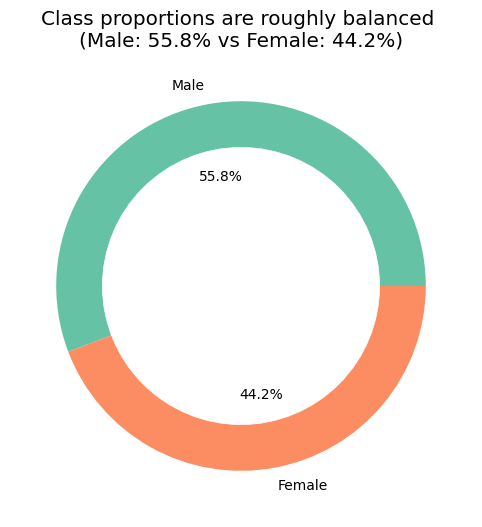

In [243]:
fig, ax = plt.subplots(figsize=(10, 6))
circle_center = plt.Circle( (0, 0), 0.75, color='white')
plt.pie(gender_df['rate'], labels=['Male', 'Female'], 
        autopct='%1.1f%%', startangle=0, 
        colors=['#66c2a5', '#fc8d62'])
p = plt.gcf()
p.gca().add_artist(circle_center)
plt.title('Class proportions are roughly balanced \n(Male: 55.8% vs Female: 44.2%)')
plt.show()
plt.show()

**Note**
- A severe imbalance is usually considered when one class is over 70% of the total sample. However, the distribution of male and female class in the target variable is roughly balanced (55.8 vs 44.2). Consequently, no treatments need to be given to balance the classes.
- For the next step, I will check the cleanliness of the column `name` before extracing features from it. The cleanliness check is performed by investigating whether names contain punctuation marks. This process is crucial because in addition to periods, Indonesian names usually contain apostrophes, especialy names with an Arabic origin (parsial or full) such as *Do'a* and *Nu'in* below. The apostrope in Indonesian usually represents the glottal stop or glottal plosive sound.
- The punctuation symbols must be removed before extracting character n-grams because the symbols will affect the n-grams, leading to potentially noise in the dataset fed to the model. 

AAAAA

In [244]:
# check punctuation marks
df[df['name'].str.contains(r'[^\w\s]', regex=True)].head()

name gender
20         habil sabilla do'a      f
96                  m. muawam      m
97   m. yassir saputra jamina      m
287             nu' in sofyan      m
298    m. charly iman nugroho      m

**Note**: The punctuation marks here will be removed using the following code. And the names will be rechecked using the same regex patterns to detect any remainders in the punctuation removal.

In [245]:
# remove punctuation marks
explore_df = df.copy()
explore_df['name'] = explore_df['name'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# check if still any punctuation marks
explore_df[explore_df['name'].str.contains(r'[^\w\s]', regex=True)].head()

Empty DataFrame
Columns: [name, gender]
Index: []

**Note**
- The dataset does not contain any punctuation marks anymore. Now, feature extraction from `name` can be carried out. 
- For analysis purposes, I will add word count, chatacter count, number of vowels and consonants. The measures will provide more understanding of names across gender status from the structural perspective, and therefore, adding importance of a linguistic analysis.
- When analyzing structural properties of names, it is actually possible to investigate consonant clusters in the names but this analysis will not include this linguistic topic. Consonant clusters will be greatly useful when the analysis focuses more on generational differences to see cultural shift. For instance, pre-generation X names, especially from Javanese ethnic, usually use one-word name with small variations in open or closed syllabic constructions (e.g., *Mar-go-no* (M) vs *Pon-i-rah* (F)). And names in gen Z onward at glance tend to be more inclusive of non-native Javanese phonemes, e.g., palato-alveolar sibilant ʃ or alveolar fricative z, in Javanese society. 

In [246]:
# extract word count and character count from name
explore_df['wordcount'] = explore_df['name'].str.split().str.len()
explore_df['charcount'] = explore_df['name'].apply(lambda x: len(x))
explore_df.head()

name gender  wordcount  charcount
0              hafizhan shidqi      m          2         15
1                gandhi wibowo      m          2         13
2  aldio mahendra purwandrarto      m          3         27
3                  benny putra      m          2         11
4         vicky vernando dasta      m          3         20

In [247]:
# function to count vowels and consonants
def count_vowels_consonants(name):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    num_vowels = sum(name.count(vowel) for vowel in vowels)
    num_consonants = sum(name.count(consonant) for consonant in consonants)
    
    return num_vowels, num_consonants

# apply function
explore_df['vowelcount'], explore_df['conscount'] = zip(*explore_df['name'].apply(count_vowels_consonants))

# display the DataFrame
explore_df.head()


name gender  wordcount  charcount  vowelcount  \
0              hafizhan shidqi      m          2         15           5   
1                gandhi wibowo      m          2         13           5   
2  aldio mahendra purwandrarto      m          3         27          10   
3                  benny putra      m          2         11           3   
4         vicky vernando dasta      m          3         20           6   

   conscount  
0          9  
1          7  
2         15  
3          7  
4         12

### **2.2 Data Analysis**
#### **2.2.1 Do numerical features follow normal distributions?**
As this section will perform a quantitative analysisis on name length, some tests on parametric assumptions, particularly normality of distribution and equal variances between groups in question, must be done to draw valid conclusions from the tests. If the series of tests indicate normal distribution and equal variances (homoescedasticity), statistical test which can be used here is an independent *t*-test for group difference. Otherwise, the non-parametric test counterpart, Mann-Whitney *U*, can be an alternative when one or two assumptions are violated.

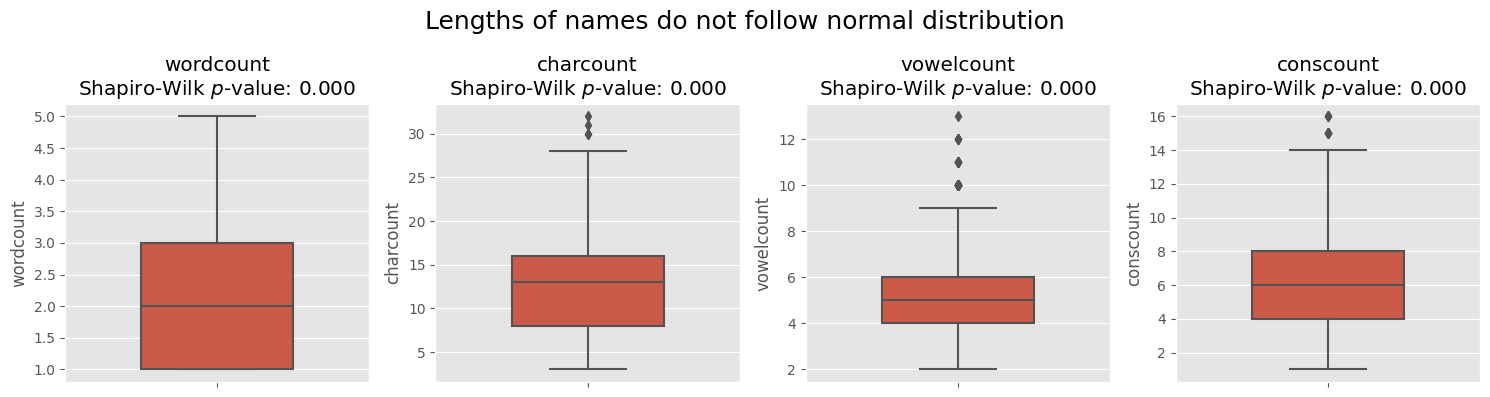

In [322]:
numerical_columns = explore_df.select_dtypes(include='number')

plt.figure(figsize=(15, 4))

# create boxplot
for i, col in enumerate(numerical_columns):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=explore_df[col], width=0.5)
    stat, p_value = shapiro(explore_df[col].dropna())
    plt.title(f'{col}\nShapiro-Wilk $p$-value: {p_value:.3f}')

plt.suptitle('Lengths of names do not follow normal distribution', size=18)
plt.tight_layout()
plt.show()

**Note**: Using Shapiro-Whilk *W* test with null hypothesis of normal distribution, the all numerical features do not follow the normal distribution (*p* < 0.05). For this reason, the assumption of normality is not met. Based on this violation of assumption only, a non-parametric test, particularly Mann-Whitney *U* test for comparing male and female names can be a primary option. But before moving forward, I will check the homoscedasticity assumption first.

In [376]:
# create function to compute kurtosis & skewness
def compute_kurtosis_and_skew(group):
    return pd.Series({
        'wordcount__kurtosis': kurtosis(group['wordcount'].dropna()),
        'wordcount__skew': skew(group['wordcount'].dropna()),
        'charcount__kurtosis': kurtosis(group['charcount'].dropna()),
        'charcount__skew': skew(group['charcount'].dropna()),
        'vowelcount__kurtosis': kurtosis(group['vowelcount'].dropna()),
        'vowelcount__skew': skew(group['vowelcount'].dropna()),
        'conscount__kurtosis': kurtosis(group['conscount'].dropna()),
        'conscount__skew': skew(group['conscount'].dropna())
    })

explore_df.groupby('gender').apply(compute_kurtosis_and_skew).transpose()

gender                       f         m
wordcount__kurtosis  -0.644453 -0.316320
wordcount__skew       0.350893  0.482408
charcount__kurtosis  -0.673870 -0.068909
charcount__skew       0.336435  0.519525
vowelcount__kurtosis -0.379800  0.169131
vowelcount__skew      0.459100  0.588126
conscount__kurtosis  -0.412962 -0.006677
conscount__skew       0.478616  0.586595

#### **2.2.2 Are the variances between male and female equal?**
To test the assumption of equal variances, I use Levene's test. This statistical test checks whether the variances between two or more groups are substantially different. If they are substantially different, the homogeneity assumption is violated.

In [377]:
numerical_columns = explore_df.select_dtypes(include='number').columns
results = []

# perform Levene's test
for col in numerical_columns:
    group1 = explore_df[explore_df['gender'] == 'm'][col].dropna()
    group2 = explore_df[explore_df['gender'] == 'f'][col].dropna()
    levene_stat, p_value = levene(group1, group2)
    conclusion = 'Variances are significantly different' if p_value < 0.05 else 'Variances are not significantly different'
    results.append({'F-stat': levene_stat, 'p-value': p_value, 'Conclusion': conclusion})

# create df to display result
pd.DataFrame(results, index=numerical_columns)

F-stat   p-value                                 Conclusion
wordcount    0.073187  0.786783  Variances are not significantly different
charcount    2.029079  0.154488  Variances are not significantly different
vowelcount   1.900265  0.168220  Variances are not significantly different
conscount   16.459019  0.000052      Variances are significantly different

**Note**
- A comparison between male and female name lengths based on different linguistic features suggest that only the number of consonants in names violates from the homogeneity of variances. Other three variables, namely `wordcount`, `charcount`, and `vowelcount`, have roughly equal variances.
- While some features indicate homogeneity of variances, these feature fail to meet the normality assumption which is strictly neeeded for a parametric test. For this reason, Mann-Whitney *U* test will be used to evaluate differences between gender statuses. This group difference test will also be complemented by rank-biserial effect size ($r$) along with the confidence interval of the effect size.
- While Mann-Whitney *U* test can tell whether there is sufficient evidence to check significant group difference, this test actually only tells a half of the story.
- Effect size, particularly rank-biserial effect size, quantfies the strength of difference between two groups. This adds practical importance of the statistical significance from the Mann-Whitney *U* test.
- Additionally, confidence interval provides a range of values for the true effect size in the population.

#### **2.2.3 Is there any significant difference between male and female in terms of word counts?**

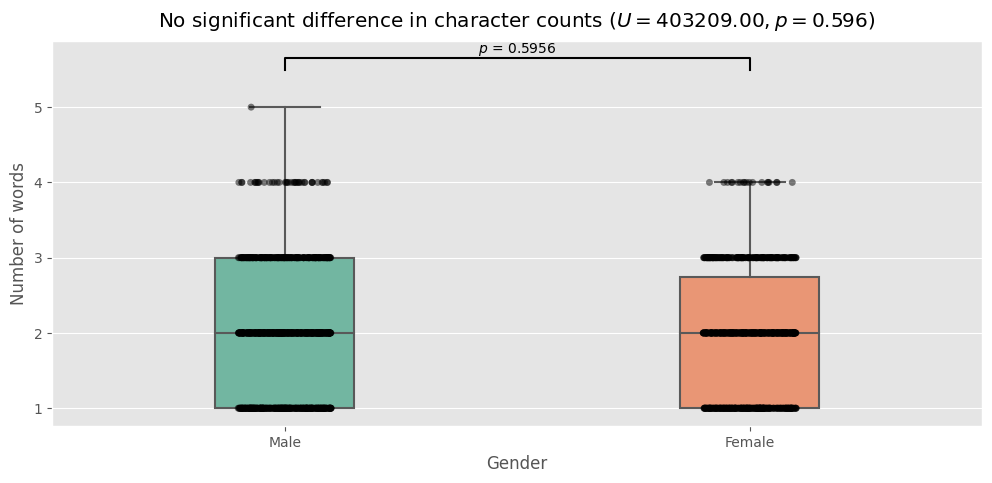

In [348]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['wordcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['wordcount']

# perform Mann-Whitney U test
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# Visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='wordcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='wordcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['wordcount'])
offset = max_y * 0.1 

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # line color

# add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'No significant difference in character counts ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of words')
current_labels = plt.gca().get_xticklabels()  
plt.gca().set_xticklabels(['Male', 'Female'])  
plt.show()

In [351]:
# create function to calculate effect size
def rank_biserial_effectsize(u_statistic, n1, n2):
    return (u_statistic - (n1 * n2 / 2)) / (n1 * n2)

# create function to compute CI
def bootstrap_ci(data1, data2, num_iterations=1000, alpha=0.05):
    boot_stats = []
    n1, n2 = len(data1), len(data2)
    
    for _ in range(num_iterations):
        sample1 = resample(data_group1)
        sample2 = resample(data_group2)
        u_statistic, _ = mannwhitneyu(sample1, sample2, alternative='two-sided')
        effect_size = rank_biserial_effectsize(u_statistic, n1, n2)
        boot_stats.append(effect_size)
    
    boot_stats = np.array(boot_stats)
    lower_bound = np.percentile(boot_stats, 100 * alpha / 2)
    upper_bound = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [361]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['wordcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['wordcount']

# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

U_stat  p-value  effect_size           95%CI
0  403209.0    0.596        0.007  [-0.017, 0.03]

**Note**
- Male and female names in terms of word counts are not statistically significant (*U* = 403209.0, *p* = 0.596). The rank-biserial effect size is very small (*r* = 0.007), suggesting a very small effect. 
- The 95% confidence interval for the effect size range between -0.017 and 0.03, which includes zero, further supporting the conclusion that there is no meaningful differtence between two gender groups.

#### **2.2.4 In terms of character counts, do male and female names have a significant difference?**

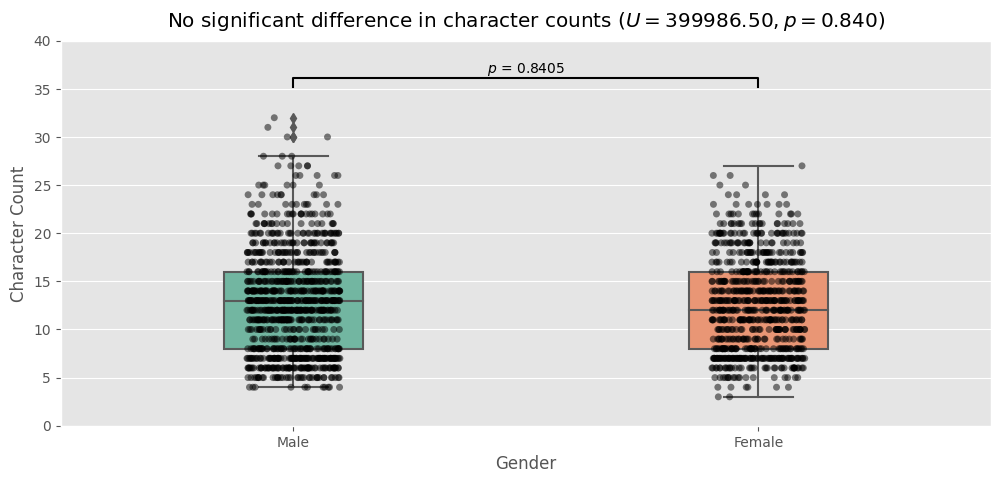

In [367]:
# Prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['charcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['charcount']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# Visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='charcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='charcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# Calculate the vertical offset for annotations
max_y = max(explore_df['charcount'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# Determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # Vertical position of the bracket
h = offset * 0.3    # Height of the bracket
col = 'k'           # Color of the line and text

# Add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'No significant difference in character counts ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Character Count')
current_labels = plt.gca().get_xticklabels()    # Get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # Replace with new labels
plt.ylim(0, 40)
plt.show()

In [368]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['charcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['charcount']

# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

U_stat  p-value  effect_size           95%CI
0  399986.5     0.84        0.003  [-0.024, 0.03]

**Note**
- Similar to previous variable, in general, the difference between male and female names in terms of character counts is minor.
- As can be seen, the probability value of the Mann-Whitney *U* test is greater than the alpha at 0.05 (*U* = 399986.5, *p* = 0.84), meaning no substantial difference between the two groups.
- The effect size (rank-biserial) is also tiny (*r* = 0.003). And to estimate the true effect size in the population, a bootstrapped 95% confidence interval was computed, resulting in an inclusion of zero range (-0.024, 0.03). 
- Altogether, these three tests indicate that two gender groups exhibit no meaningful difference in terms of character counts.

#### **2.2.5 Do males and females have significant differences in the number of vowels?**

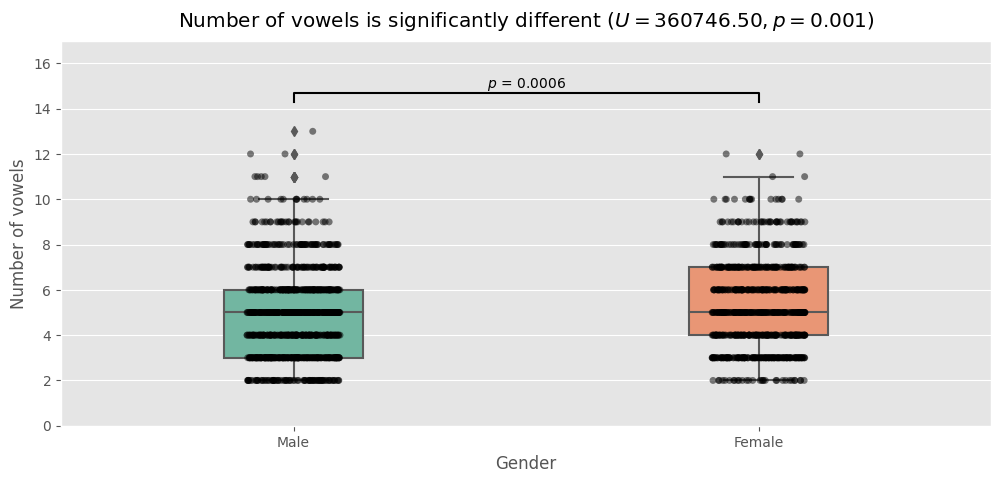

In [380]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['vowelcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['vowelcount']

# perform Mann-Whitney U 
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='vowelcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='vowelcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['vowelcount'])
offset = max_y * 0.1  

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # color of the line and text

# Add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'Number of vowels is significantly different ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of vowels')
current_labels = plt.gca().get_xticklabels()    # get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # replace with new labels
plt.ylim(0, 17)
plt.show()

In [379]:
# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

U_stat  p-value  effect_size             95%CI
0  360746.5    0.001       -0.047  [-0.073, -0.019]

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **2.2.6 Is the number of consonants across gender significantly different?**

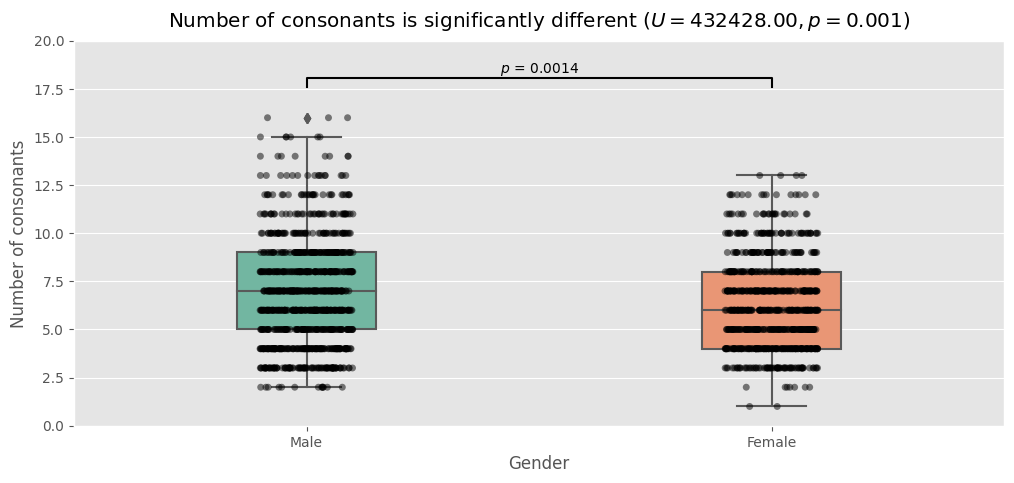

In [371]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['conscount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['conscount']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_group1, data_group2)

# visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='conscount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='conscount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['conscount'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # color of the line and text

# add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'Number of consonants is significantly different ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of consonants')
current_labels = plt.gca().get_xticklabels()    # get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # replace with new labels
plt.ylim(0, 20)
plt.show()

In [372]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['conscount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['conscount']

# calculate Mann-Whitney U
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

U_stat  p-value  effect_size           95%CI
0  432428.0    0.001        0.044  [0.018, 0.069]

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **2.3 Summary**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum


Jelasin kalo bagian ini cuma buat nambah pengetahuan saja, tidak untuk modeling. Karena pendekatannya beda. Predictive modeling menggunakan linguistic representation character n-grams (sequence of characters) sementara sttaistical analysis berfokus pada beberapa linguistic representations seperti words, vocal/konsonan, dan character count

## **3 Predictive Modeling**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **3.1 Data Preparation**

In [257]:
# remove punctuations
class RemovePunctuation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series):
            return X.apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
        elif isinstance(X, list):
            return pd.Series(X).apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
        else:
            raise ValueError("Input should be a series or list of strings.")

In [258]:
# split the data
X = df['name']
y = df['gender'].apply(lambda x: 1 if x == 'm' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Sample size: {df.shape}')
print(f'- X_train dimension: {X_train.shape}')
print(f'- y_train lenght: {len(y_train)}')
print(f'- X_test dimension: {X_test.shape}')
print(f'- y_test lenght: {len(y_test)}')

Sample size: (1796, 2)
- X_train dimension: (1436,)
- y_train lenght: 1436
- X_test dimension: (360,)
- y_test lenght: 360


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [374]:
# create preprocessor pipelinee
preprocessor = Pipeline([
    ('remove_punctuation', RemovePunctuation()),
    ('vectorizer', CountVectorizer(analyzer='char_wb', ngram_range=(3, 3)))
])

display(preprocessor)

Pipeline(steps=[('remove_punctuation', RemovePunctuation()),
                ('vectorizer',
                 CountVectorizer(analyzer='char_wb', ngram_range=(3, 3)))])

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [375]:
# fit and transform X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# get feature names from the vectorizer
feature_names = preprocessor.named_steps['vectorizer'].get_feature_names_out()

# convert the sparse matrix to df
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns=feature_names)

# display output
display(X_train_transformed_df.head())

a    aa   ab   ac   ad   ae   af   ag   ah   ai  ...  zri  zub  zuh  zuk  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   zul  zun  zwa  zwi  zza  zzu  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 2155 columns]

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [260]:
# Define scoring metrics
scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Specify models for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)), 
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# Assemble everything in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])) for name, model in classifiers]

In [261]:
# use stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **3.2 Model Comparison**

In [262]:
# Evaluate each model
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

# DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')

In [263]:
# Display results
results_df.sort_values(by='f1', ascending=False) 

f1  f1_sd  accuracy  accuracy_sd  recall  \
Model                                                                 
Support Vector Machine  0.934  0.006     0.925        0.006   0.939   
Logistic Regression     0.931  0.010     0.922        0.010   0.932   
Random Forest           0.925  0.004     0.916        0.005   0.917   
XGBoost                 0.918  0.005     0.908        0.007   0.918   
CatBoost                0.914  0.010     0.903        0.010   0.921   
Gradient Boosting       0.908  0.012     0.893        0.015   0.929   
Decision Tree           0.894  0.004     0.881        0.004   0.895   
AdaBoost                0.894  0.010     0.881        0.012   0.896   
K-Nearest Neighbors     0.855  0.020     0.845        0.018   0.813   

                        recall_sd  roc_auc  roc_auc_sd  training_time  
Model                                                                  
Support Vector Machine      0.020    0.924       0.005          2.308  
Logistic Regression         0.023    0.921       0.009          3.093  
Random Forest               0.010    0.916       0.006          0.907  
XGBoost                     0.018    0.907       0.009          0.415  
CatBoost                    0.030    0.900       0.008         16.930  
Gradient Boosting           0.022    0.888       0.017          0.720  
Decision Tree               0.022    0.879       0.005          0.175  
AdaBoost                    0.013    0.879       0.014          0.378  
K-Nearest Neighbors         0.035    0.850       0.016          0.166

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **3.3 Model Building**

In [264]:
# specify top-3 models
clf_SVM = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', SVC(probability=True))
])
clf_LR = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])
clf_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# fit each model on training set
clf_SVM.fit(X_train, y_train)
clf_LR.fit(X_train, y_train)
clf_RF.fit(X_train, y_train)

# evaluate each model on validation set
y_pred_SVM = clf_SVM.predict(X_test)
y_pred_LR = clf_LR.predict(X_test)
y_pred_RF = clf_RF.predict(X_test)

In [265]:
# Define a function to compute metrics including ROC AUC
def compute_metrics(y_true, y_pred, y_prob=None):
    metrics = {
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    return metrics

# Evaluate SVM classifier
y_prob_SVM = clf_SVM.predict_proba(X_test)[:, 1]
metrics_SVM = compute_metrics(y_test, y_pred_SVM, y_prob_SVM)

# Evaluate Logistic Regression classifier
y_prob_LR = clf_LR.predict_proba(X_test)[:, 1]
metrics_LR = compute_metrics(y_test, y_pred_LR, y_prob_LR)

# Evaluate Random Forest classifier
y_prob_RF = clf_RF.predict_proba(X_test)[:, 1]
metrics_RF = compute_metrics(y_test, y_pred_RF, y_prob_RF)

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['SVM', 'Logistic Regression', 'Random Forest'],
    'F1 Score': [metrics_SVM['f1'], metrics_LR['f1'], metrics_RF['f1']],
    'Precision': [metrics_SVM['precision'], metrics_LR['precision'], metrics_RF['precision']],
    'Recall': [metrics_SVM['recall'], metrics_LR['recall'], metrics_RF['recall']],
    'ROC AUC': [metrics_SVM.get('roc_auc', 'N/A'), metrics_LR.get('roc_auc', 'N/A'), metrics_RF.get('roc_auc', 'N/A')]
}).round(3)

# Set 'Model' column as index
metrics_df.set_index('Model', inplace=True)

display(metrics_df)

F1 Score  Precision  Recall  ROC AUC
Model                                                    
SVM                     0.944      0.935   0.954    0.978
Logistic Regression     0.934      0.925   0.944    0.972
Random Forest           0.931      0.924   0.938    0.972

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **3.3 Hyperparameter Tuning**

In [266]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Create GridSearchCV
grid_svm = GridSearchCV(clf_SVM, param_grid_svm, cv=10, scoring='f1', n_jobs=-1)

# Fit the grid search
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('remove_punctuation',
                                                         RemovePunctuation()),
                                                        ('vectorizer',
                                                         CountVectorizer(analyzer='char_wb',
                                                                         ngram_range=(3,
                                                                                      3)))])),
                                       ('classifier', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1')

In [267]:
pd.options.display.max_colwidth = None

best_index = grid_svm.best_index_
std_test_score = grid_svm.cv_results_['std_test_score'][best_index]

# Store tuned version result
exp1_tuned = pd.DataFrame({
    'Model': ['SVM'],
    'Best Parameters': [
        grid_svm.best_params_,
    ],
    'Best F1 Score': [
        grid_svm.best_score_,
    ],
    'Std': [
        std_test_score,
    ]
}).round(3)
exp1_tuned

Model  \
0   SVM   

                                                                        Best Parameters  \
0  {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}   

   Best F1 Score    Std  
0          0.941  0.007

In [268]:
# Assuming grid_svm is the fitted GridSearchCV object for SVM
best_SVM = grid_svm.best_estimator_  
y_pred_SVM = best_SVM.predict(X_test) 

# Compute metrics
metrics_SVM = {
    'F1 Score': f1_score(y_test, y_pred_SVM),
    'Precision': precision_score(y_test, y_pred_SVM),
    'Recall': recall_score(y_test, y_pred_SVM),
    'Accuracy': accuracy_score(y_test, y_pred_SVM),
    'ROC AUC': roc_auc_score(y_test, best_SVM.predict_proba(X_test)[:, 1])
}

# convert to DataFrame
metrics_df = pd.DataFrame([metrics_SVM]).round(3)
display(metrics_df)

F1 Score  Precision  Recall  Accuracy  ROC AUC
0     0.946      0.944   0.949     0.942    0.974

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### **3.4 Final Model**

In [269]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, C=0.1, gamma='scale', kernel='linear'))
])

# fit the pipeline on the training data
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = final_model.predict(X_test)

# predict probability
y_prob_test = final_model.predict_proba(X_test)[:, 1]

# final_model_metrics = pd.DataFrame(compute_metrics(y_test, y_pred_test, y_prob_test))
# final_model_metrics

In [270]:
display(pd.DataFrame(compute_metrics(y_test, y_pred_test, y_prob_test), index=[0]).round(3))
print(classification_report(y_test, y_pred_test))

f1  precision  recall  roc_auc
0  0.946      0.944   0.949    0.974

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       165
           1       0.94      0.95      0.95       195

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.1 ROC-AUC Curve**

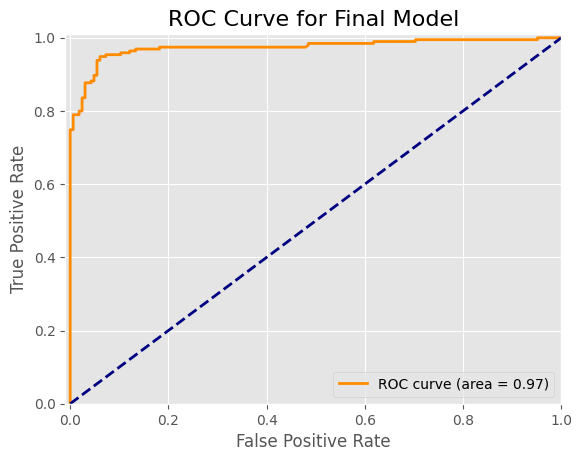

In [271]:
# Plot ROC AUC curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Model', fontsize=16)
plt.legend(loc="lower right")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.2 Precision Recall Curve**

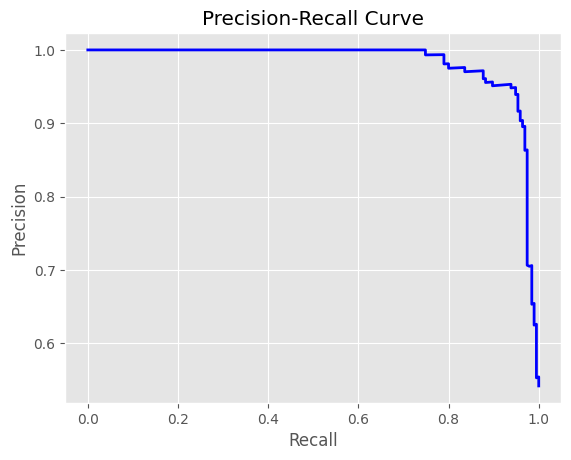

In [272]:
# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.3 Learning Curve**

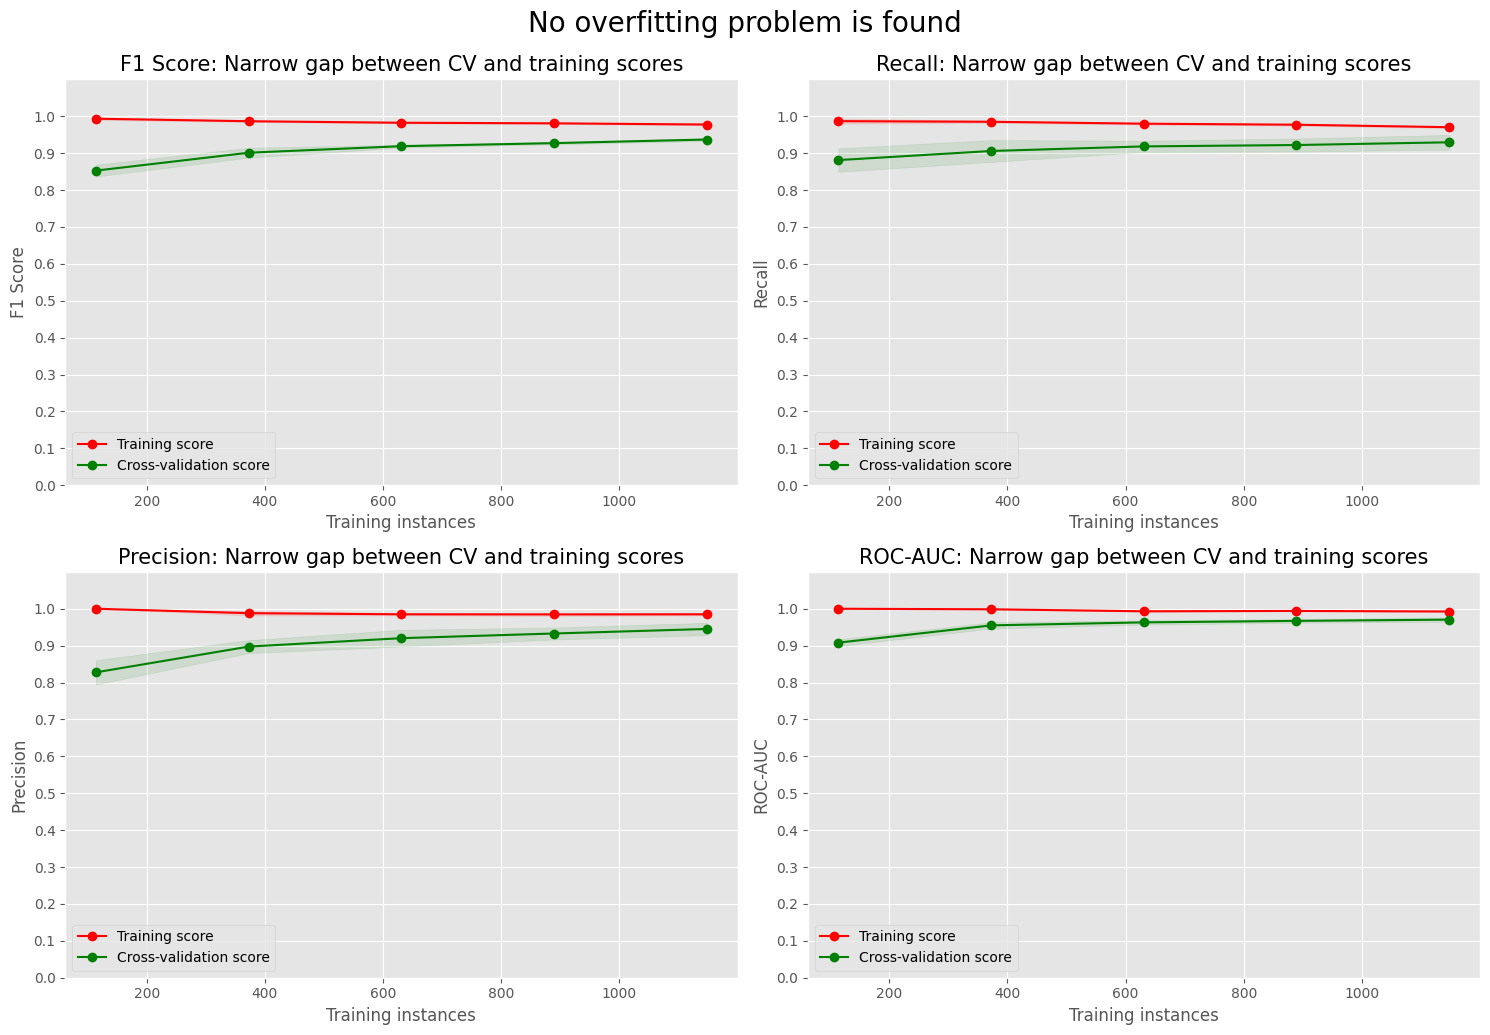

In [273]:
# Define the metrics
metrics = {
    'F1 Score': 'f1',
    'Recall': 'recall',
    'Precision': 'precision',
    'ROC-AUC': 'roc_auc'
}

# Initialize the figure and axis array
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Loop through each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        final_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[i].set_xlabel('Training instances')
    axes[i].set_ylabel(metric_name)
    axes[i].set_title(f'{metric_name}: Narrow gap between CV and training scores', size=15)
    axes[i].legend(loc="best")
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticks(np.arange(0, 1.1, 0.1))

# Adjust layout
plt.tight_layout()
plt.suptitle('No overfitting problem is found', y=1.03, size=20)
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.4 Calibration Curve**

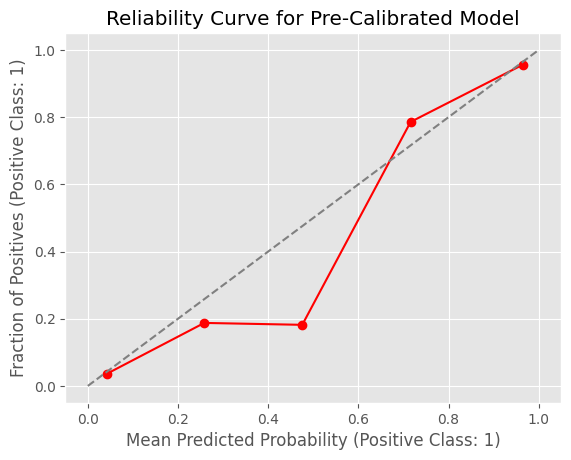

In [274]:
# Predict probabilities on the test set
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Plot Reliability Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=5)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Pre-Calibrated Model')
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

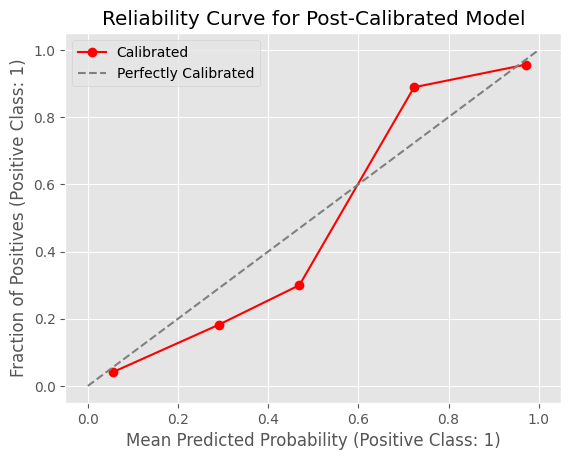

In [275]:
calibrated_clf = CalibratedClassifierCV(estimator=final_model, method='isotonic')
calibrated_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=5)

# Plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Post-Calibrated Model')
plt.legend(loc='best')
plt.show()


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

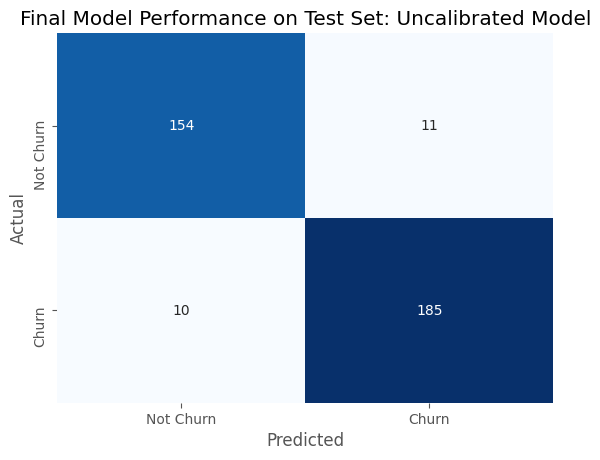

In [276]:
# predict on the test set
y_pred_test = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Uncalibrated Model')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

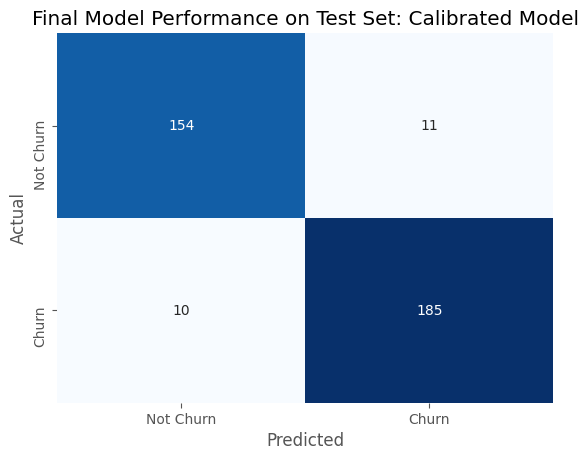

In [277]:
# predict on the test set
y_pred_test = calibrated_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Calibrated Model')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.5 Feature Importance**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [278]:
# Access the classifier and vectorizer from the pipeline
classifier = final_model.named_steps['classifier']
vectorizer = final_model.named_steps['preprocessor'].named_steps['vectorizer']

# Check if the classifier has coefficients (linear SVM)
if hasattr(classifier, 'coef_'):
    coefficients = classifier.coef_.toarray().flatten()  # Convert sparse matrix to dense array and flatten
    transformed_feature_names = vectorizer.get_feature_names_out()
    
    # Ensure that the coefficients and feature names match in length
    if len(coefficients) == len(transformed_feature_names):
        # Create a DataFrame with the feature importance
        feature_importance = pd.DataFrame({
            'Feature': transformed_feature_names,
            'Importance': coefficients
        })

        # Sort by absolute importance
        feature_importance['Absolute_Importance'] = feature_importance['Importance'].abs()
        feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

        # Drop 'Absolute_Importance'
        feature_importance.drop(columns=['Absolute_Importance'], inplace=True)

        # Display feature importance
        display(feature_importance.head(10))
    else:
        print("Error: The number of coefficients does not match the number of features.")
else:
    print("Error: The classifier does not have a `coef_` attribute.")

Feature  Importance
231      ah    -0.981006
1823     ti    -0.929204
629      em    -0.901181
1335     ni    -0.776838
1290     na    -0.653980
1249     mi    -0.639472
1709     sih   -0.625678
1138     la    -0.616912
380      atu   -0.615647
875      ia    -0.594742

In [279]:
# Filter out rows where the 'Feature' column has single-character strings
# Replace spaces with $ in the 'Feature' column
feature_importance2 = feature_importance.copy()
feature_importance2['Feature'] = feature_importance2['Feature'].str.replace(' ', '_')
feature_importance2 = feature_importance2.head(20)
feature_importance2 = feature_importance2.sort_values(by='Importance')
feature_importance2

Feature  Importance
231      ah_   -0.981006
1823     ti_   -0.929204
629      em_   -0.901181
1335     ni_   -0.776838
1290     na_   -0.653980
1249     mi_   -0.639472
1709     sih   -0.625678
1138     la_   -0.616912
380      atu   -0.615647
875      ia_   -0.594742
374      ati   -0.574031
307      ani   -0.485554
964      ini   -0.482558
1862     tun   -0.455873
1361     no_    0.479708
1851     tra    0.487642
313      ans    0.505239
1843     to_    0.573750
504      dan    0.584727
301      an_    0.589402

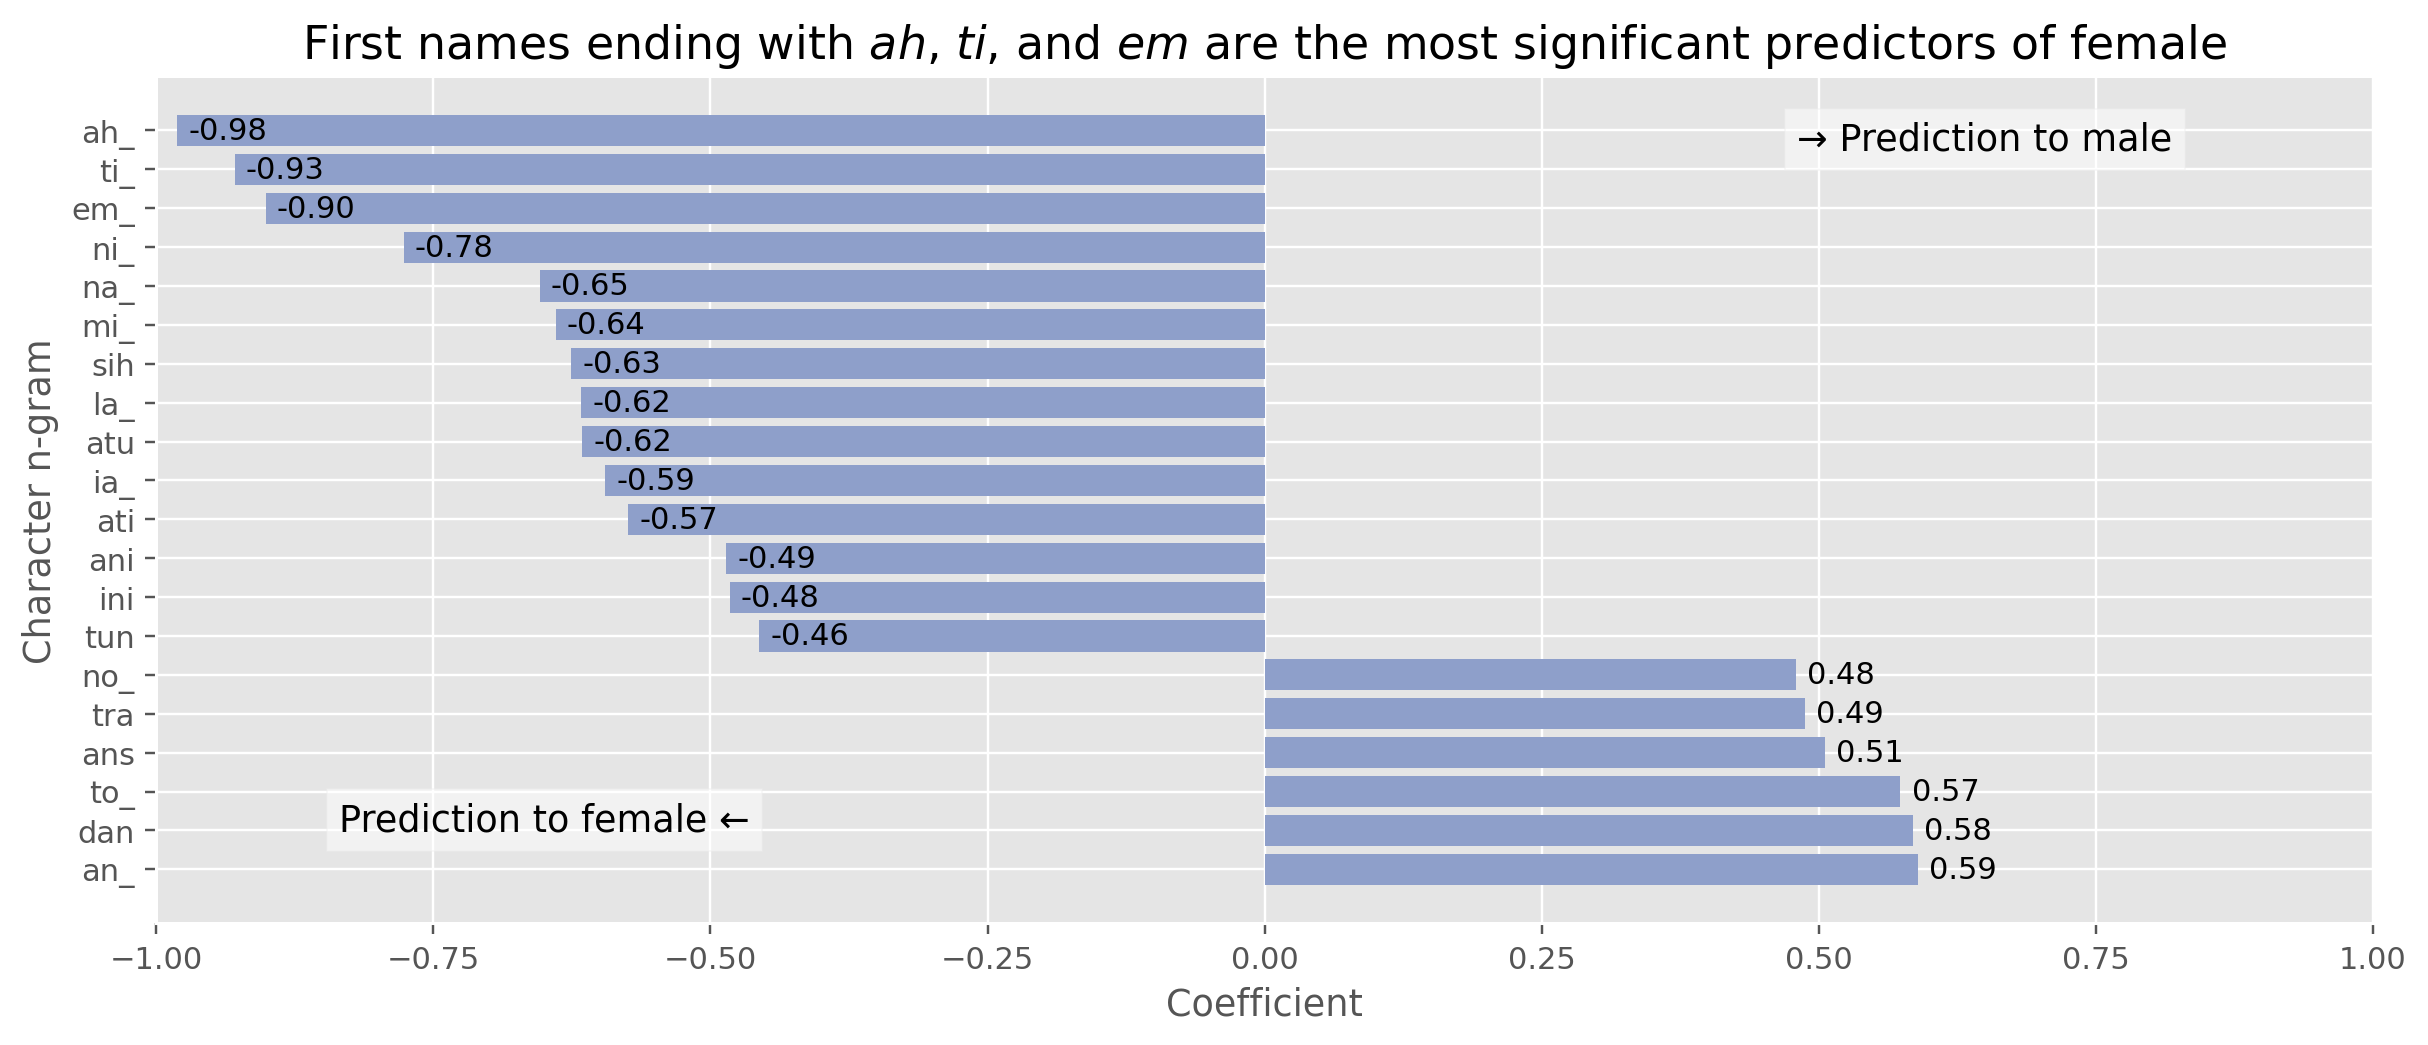

In [382]:
# visualize feature importance
plt.figure(figsize=(13, 5), dpi=220)
bars = plt.barh(feature_importance2['Feature'], feature_importance2['Importance'], color='#8e9fca')

# add data labels 
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,                 # position slightly to the right of the bar end
        bar.get_y() + bar.get_height() / 2,     # vertical position at the center of the bar
        f'{bar.get_width():.2f}',               # format the coefficient value to 2 decimal places
        va='center',                            # vertical alignment
        ha='left',                              # horizontal alignment
        fontsize=10,                            
        color='black'                           
    )
plt.text(0.65, 0.5, '→ Prediction to male', 
         bbox=dict(facecolor='white', alpha=0.5), 
         fontsize=12, color='black', ha='center')
plt.text(-0.65, 18, 'Prediction to female ←',
         bbox=dict(facecolor='white', alpha=0.5), 
         fontsize=12, color='black', ha='center')

plt.xlabel('Coefficient')
plt.title(f'First names ending with $ah$, $ti$, and $em$ are the most significant predictors of female', size=15)
plt.ylabel('Character n-gram')
plt.gca().invert_yaxis()                       
plt.xlim(-1, 1)
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.6 Local Interpretable Model-Agnostic Explanations**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [281]:
df_seen = pd.DataFrame({'name':X_train, 'gender':y_train})
df_seen['gender'] = df_seen['gender'].apply(lambda x: 'm' if x == 1 else 'f')

In [282]:
df_seen[(df_seen['name'].str.contains(r'^\w+ah\s', regex=True)) & (df_seen['gender'] == 'f')]

name gender
598            indah kurnia sari      f
1731            diah ayu safitri      f
823               aisyah giovani      f
126              indah rahmawati      f
41               zakiah nurviani      f
94            indah permata sari      f
1835              afifah mariani      f
1687               indah mawarni      f
660   azzah rotun nisa almufidah      f
1001            indah bunga hati      f
1284               fadhilah aini      f
1782         hasnah elfina warda      f
1309               atiah azzaroh      f
758                endah susanti      f
1809           kamilah mubarokah      f
1560             indah fatmawati      f

In [283]:
df_seen[(df_seen['name'].str.contains(r'^\w+ah\s', regex=True)) & (df_seen['gender'] == 'm')]

name gender
1243          lamsyah purba      m
957   abdullah afif azzuhri      m
412     aissyah dwi zhaskia      m
125        hijrah syahputra      m
22       ibnuyohanzah ahmad      m

In [284]:
# Make predictions on the test set
y_pred = calibrated_clf.predict(X_test)

# Get the predicted probabilities for each class
y_prob = calibrated_clf.predict_proba(X_test)

# Combine the predictions and probabilities into a DataFrame
predictions_df = pd.DataFrame({
    'Name': X_test,
    'Actual': y_test,
    'Predicted': y_pred,
    'ProbM': y_prob[:, 1],  # Probability of 'Male'
    'ProbF': y_prob[:, 0],  # Probability of 'Female'
}).round(2)

predictions_df['FN'] = (predictions_df['Actual'] == 1) & (predictions_df['Predicted'] == 0)
predictions_df['FP'] = (predictions_df['Actual'] == 0) & (predictions_df['Predicted'] == 1)

predictions_df.head()

Name  Actual  Predicted  ProbM  ProbF     FN     FP
1351     wahyu redyansyah       1          1   0.71   0.29  False  False
221   yunaldi rizki putra       1          1   1.00   0.00  False  False
1653     thamrin simamora       1          1   1.00   0.00  False  False
441               samiyah       0          0   0.09   0.91  False  False
1386     suci ayu mawarni       0          0   0.02   0.98  False  False

In [285]:
predictions_df[(predictions_df['Name'].str.contains(r'^\w+ah\s', regex=True))]

Name  Actual  Predicted  ProbM  ProbF     FN     FP
468           hamzah maulana       1          0   0.31   0.69   True  False
1523    afiah rohadatul aisy       0          0   0.00   1.00  False  False
357     khasanah dwi fauziah       0          0   0.00   1.00  False  False
1019  azizah hanifatur rahma       0          0   0.05   0.95  False  False
958          afifah azzahroh       0          0   0.03   0.97  False  False
1832      rahmidiah ediyanti       0          0   0.00   1.00  False  False

In [286]:
from lime.lime_text import LimeTextExplainer

# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Female', 'Male'])

# Ensure text_instance is a single string
text_instance = predictions_df[(predictions_df['Name'].str.contains(r'^\w+ah\s', regex=True))].iloc[3, 0]
print(f'Gender to predict: {text_instance}')        

# Ensure the classifier function is correct
def predict_proba_fn(texts):
    return calibrated_clf.predict_proba(texts)

# Explain the instance
exp = explainer.explain_instance(text_instance, 
                                 predict_proba_fn, 
                                 num_features=50)

# Display the explanation
exp.show_in_notebook(text=True)

Gender to predict: azizah hanifatur rahma


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [287]:
# initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Female', 'Male'])

text_instance = predictions_df['Name'].iloc[77]
print(f'Gender to predict: {text_instance}')        

# Ensure the classifier function is correct
def predict_proba_fn(texts):
    return calibrated_clf.predict_proba(texts)

# Explain the instance
exp = explainer.explain_instance(text_instance, 
                                 predict_proba_fn, 
                                 num_features=50)

# Display the explanation
exp.show_in_notebook(text=True)

Gender to predict: muhammad azmy


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### **3.4.7 Error Analysis**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [288]:
mispredictions = predictions_df[predictions_df['Actual'] != predictions_df['Predicted']]
mispredictions_cnt = len(mispredictions)
misprediction_rate = len(mispredictions)/len(predictions_df)*100
type1_errors = mispredictions[mispredictions['FP'] == True]
type2_errors = mispredictions[mispredictions['FN'] == True]
print(f'Misprediction in total: {mispredictions_cnt} (or {misprediction_rate:.2f}%)')
print(f'Total false positives: {len(type1_errors)}')
print(f'Total false negatives: {len(type2_errors)}')
display(mispredictions.head())

Misprediction in total: 21 (or 5.83%)
Total false positives: 11
Total false negatives: 10


Name  Actual  Predicted  ProbM  ProbF     FN     FP
213   ridha ulva       0          1   0.93   0.07  False   True
1341       temen       0          1   0.84   0.16  False   True
369    air murya       0          1   0.90   0.10  False   True
300     sarminah       1          0   0.03   0.97   True  False
933   evi alisma       0          1   0.94   0.06  False   True

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [289]:
# discretize prediction score 1
mispredictions = mispredictions.copy()
bin = pd.cut(mispredictions['ProbM'], bins=4, labels=False)
mispredictions['Group'] = bin
bin_counts = mispredictions['Group'].value_counts().sort_index()
# see result
mispredictions.head()

Name  Actual  Predicted  ProbM  ProbF     FN     FP  Group
213   ridha ulva       0          1   0.93   0.07  False   True      3
1341       temen       0          1   0.84   0.16  False   True      3
369    air murya       0          1   0.90   0.10  False   True      3
300     sarminah       1          0   0.03   0.97   True  False      0
933   evi alisma       0          1   0.94   0.06  False   True      3

Group  FN  FP
0      0   6   0
1      1   3   0
2      2   1   2
3      3   0   9

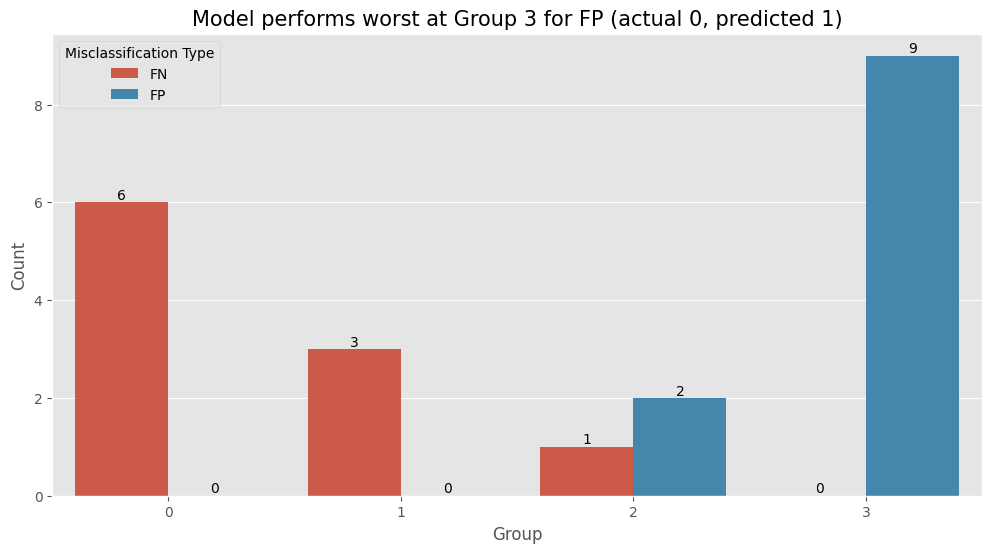

In [290]:
# calculate misclassifications

# group by 'Group' and count FNs and FPs
fn_fp_by_group = mispredictions.groupby('Group')[['FN', 'FP']].sum().reset_index()

display(fn_fp_by_group)

# plot the data
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Group', y='value', hue='variable', data=pd.melt(fn_fp_by_group, ['Group']))

# add labels on top
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                xy=(p.get_x() + p.get_width() / 2., height),
                xytext=(0, 5),  
                textcoords='offset points',
                ha='center', va='center')

plt.title('Model performs worst at Group 3 for FP (actual 0, predicted 1)', fontsize=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Misclassification Type')
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [291]:
mispredictions.groupby('Group').agg(func={'ProbM':'mean'}).round(3)

ProbM
Group       
0      0.065
1      0.373
2      0.510
3      0.870

### **3.5 Final Model Saving**

In [305]:
import joblib
joblib.dump(calibrated_clf, '../model/final_model.pkl')
print('Model saved!')

Model saved!


## **4 Conclusions and Future Directions**

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

In [373]:
import numpy as np
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_size = 0.0871  # The effect size you aim for (Rank-Biserial Correlation Coefficient)
alpha = 0.05  # Significance level
power = 0.80  # Desired power (1 - beta)

# Power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

print(f"Ideal sample size for each group: {np.ceil(sample_size)}")

Ideal sample size for each group: 2071.0
